# Nama: Rendi Salim
# Email: rendisalim10@gmail.com

In [1]:
%cd //

/


In [2]:
!pip install -q kaggle
from google.colab import files
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"rendisalim","key":"55568953d6444ba3a11f024b00fb8394"}'}

In [3]:
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!ls ~/.kaggle
!chmod 600 /root/.kaggle/kaggle.json 

kaggle.json


In [4]:
!kaggle datasets download -d datamunge/sign-language-mnist -p /SignLanguageProject

 91% 57.0M/62.6M [00:02<00:00, 32.6MB/s]
100% 62.6M/62.6M [00:02<00:00, 30.2MB/s]


In [5]:
#Extract data 
import zipfile, os
localZip = '/SignLanguageProject/sign-language-mnist.zip'
zipRef = zipfile.ZipFile(localZip, 'r')
zipRef.extractall('/SignLanguageProject/data')
zipRef.close()

In [6]:
%cd /SignLanguageProject/data/sign_mnist_train

/SignLanguageProject/data/sign_mnist_train


In [7]:
import pandas as pd

sign = pd.read_csv('sign_mnist_train.csv')
sign.head()

,label,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,pixel9,pixel10,pixel11,pixel12,pixel13,pixel14,pixel15,pixel16,pixel17,pixel18,pixel19,pixel20,pixel21,pixel22,pixel23,pixel24,pixel25,pixel26,pixel27,pixel28,pixel29,pixel30,pixel31,pixel32,pixel33,pixel34,pixel35,pixel36,pixel37,pixel38,pixel39,...,pixel745,pixel746,pixel747,pixel748,pixel749,pixel750,pixel751,pixel752,pixel753,pixel754,pixel755,pixel756,pixel757,pixel758,pixel759,pixel760,pixel761,pixel762,pixel763,pixel764,pixel765,pixel766,pixel767,pixel768,pixel769,pixel770,pixel771,pixel772,pixel773,pixel774,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783,pixel784
0,3,107,118,127,134,139,143,146,150,153,156,158,160,163,165,159,166,168,170,170,171,171,171,172,171,171,170,170,169,111,121,129,135,141,144,148,151,154,157,160,...,205,206,206,207,207,206,206,204,205,204,203,202,142,151,160,172,196,188,188,190,135,96,86,77,77,79,176,205,207,207,207,207,207,207,206,206,206,204,203,202
1,6,155,157,156,156,156,157,156,158,158,157,158,156,154,154,153,152,151,149,149,148,147,146,144,142,143,138,92,108,158,159,159,159,160,160,160,160,160,160,160,...,100,78,120,157,168,107,99,121,133,97,95,120,135,116,95,79,69,86,139,173,200,185,175,198,124,118,94,140,133,84,69,149,128,87,94,163,175,103,135,149
2,2,187,188,188,187,187,186,187,188,187,186,185,185,185,184,184,184,181,181,179,179,179,178,178,109,52,66,77,83,188,189,189,188,188,189,188,188,188,188,187,...,203,204,203,201,200,200,199,198,196,195,194,193,198,166,132,114,89,74,79,77,74,78,132,188,210,209,206,205,204,203,202,201,200,199,198,199,198,195,194,195
3,2,211,211,212,212,211,210,211,210,210,211,209,207,208,207,206,203,202,201,200,198,197,195,192,197,171,51,52,54,212,213,215,215,212,212,213,212,212,211,211,...,247,242,233,231,230,229,227,225,223,221,220,216,58,51,49,50,57,60,17,15,18,17,19,1,159,255,237,239,237,236,235,234,233,231,230,226,225,222,229,163
4,13,164,167,170,172,176,179,180,184,185,186,188,189,189,190,191,189,190,190,187,190,192,193,191,191,192,192,194,194,166,169,172,174,177,180,182,185,186,187,190,...,90,77,88,117,123,127,129,134,145,152,156,179,105,106,105,104,104,104,175,199,178,152,136,130,136,150,118,92,85,76,92,105,105,108,133,163,157,163,164,179


In [8]:
sign['label'].value_counts().sort_index()

0     1126
1     1010
2     1144
3     1196
4      957
5     1204
6     1090
7     1013
8     1162
10    1114
11    1241
12    1055
13    1151
14    1196
15    1088
16    1279
17    1294
18    1199
19    1186
20    1161
21    1082
22    1225
23    1164
24    1118
Name: label, dtype: int64

In [9]:
print('Jumlah Pixel Gambar: ', sign.shape[1])
print('Jumlah Dataset: ', sign.shape[0])

Jumlah Pixel Gambar:  785
Jumlah Dataset:  27455


In [10]:
pixel = sign.iloc[:, 1:]
label = sign['label']
print(pixel.shape)
print(label.shape)

(27455, 784)
(27455,)


In [11]:
#mengubah label menjadi letter
alphabet = 'abcdefghijklmnopqrstuvwxyz'
letter = {}

for i,j in enumerate(alphabet):
  letter[i] = j

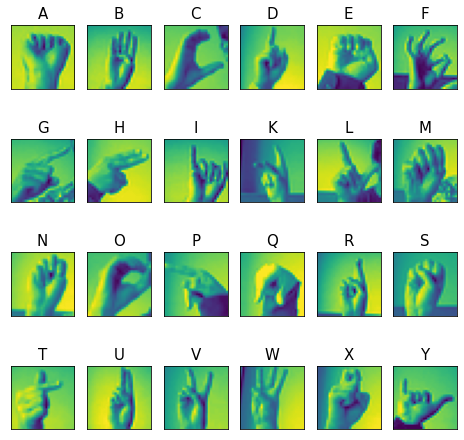

In [12]:
#Plot Sample Gambar
import matplotlib.pyplot as plt

fig, axes = plt.subplots(nrows=4, ncols=6, figsize=(8, 8),
                        subplot_kw={'xticks': [], 'yticks': []})

for i, ax in enumerate(axes.flat):
  if i >= 9:
    i += 1
  img = sign[sign['label'] == i].iloc[0].drop('label', axis = 0).values.reshape(28,28)
  ax.imshow(img)
  title = letter[sign[sign['label'] == i].iloc[0,0]]
  ax.set_title(title.upper(), fontsize = 15)
plt.show()

In [13]:
#Split data
from sklearn.model_selection import train_test_split

xTrain, xTest, yTrain, yTest = train_test_split(pixel, label, random_state = 42, test_size = 0.2)

print(len(xTrain))

21964


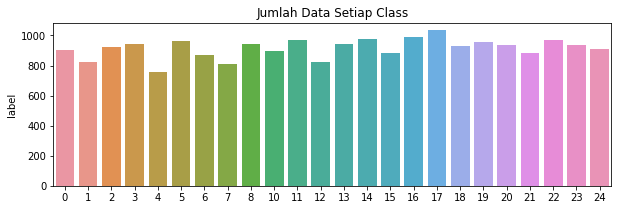

In [14]:
import seaborn as sns

jumlahDataPerClass = pd.Series(yTrain).value_counts().sort_index()
plt.figure(figsize=(10,3))
sns.barplot(x = jumlahDataPerClass.index, y = jumlahDataPerClass)
plt.title('Jumlah Data Setiap Class')
plt.show()

In [15]:
#Balancing Class

from imblearn.over_sampling import SMOTE
smote = SMOTE(random_state = 42)
xTrainBalance, yTrainBalance = smote.fit_resample(xTrain, yTrain)

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


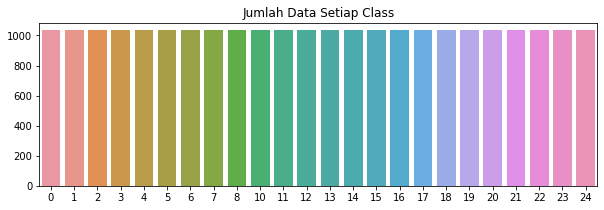

In [16]:
jumlahDataPerClass = pd.Series(yTrainBalance).value_counts().sort_index()
plt.figure(figsize=(10,3))
sns.barplot(x = jumlahDataPerClass.index, y = jumlahDataPerClass)
plt.title('Jumlah Data Setiap Class')
plt.show()

In [17]:
#reshape data

print('Before X Train Reshape: ', xTrainBalance.shape)
xTrainBalance = xTrainBalance.reshape(-1,28,28,1)
print('After X Train Reshape: ', xTrainBalance.shape)
print('Y Train Shape: ', yTrainBalance.shape)

print('Before X Test Reshape: ', xTest.shape)
xTest = xTest.values.reshape(-1,28,28,1)
print('After X Train Reshape: ', xTest.shape)
print('Y Test Shape: ', yTest.shape)

Before X Train Reshape:  (24792, 784)
After X Train Reshape:  (24792, 28, 28, 1)
Y Train Shape:  (24792,)
Before X Test Reshape:  (5491, 784)
After X Train Reshape:  (5491, 28, 28, 1)
Y Test Shape:  (5491,)


In [18]:
#Data Augmentation
from tensorflow.keras.preprocessing.image import ImageDataGenerator

trainDataGen = ImageDataGenerator(
    rescale = 1./255,
    zoom_range = 0.1,
    shear_range = 0.1,
    rotation_range = 5,
    height_shift_range = 0.05,
    width_shift_range = 0.05,
    horizontal_flip = True,
    fill_mode = 'nearest'
)

valDataGen = ImageDataGenerator(
    rescale = 1./255
)

In [19]:
#Buat Data Training dan Validation
trainGenerator = trainDataGen.flow(xTrainBalance,
                                   yTrainBalance,
                                   batch_size = 32)

valGenerator = valDataGen.flow(xTest,
                               yTest,
                               batch_size = 32)

In [20]:
#Callback 
import tensorflow as tf

class Callback(tf.keras.callbacks.Callback):
  def on_epoch_end(self, epoch, logs={}):
    if(logs.get('accuracy') > 0.92 and logs.get('val_accuracy') > 0.92):
      self.model.stop_training = True

callbacks = Callback()

In [21]:
#Reduce learning rate
from tensorflow.keras.callbacks import ReduceLROnPlateau
reduceLR = ReduceLROnPlateau(
    monitor = 'val_loss',
    factor = 0.2,
    patience = 5,
    min_lr = 1e-4
)

In [22]:
import tensorflow as tf

model = tf.keras.models.Sequential([
    tf.keras.layers.Conv2D(64, (3,3), activation = 'relu', padding = 'same', input_shape = (28,28,1)),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.MaxPooling2D((2,2), padding = 'same'),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Conv2D(64, (3,3), activation = 'relu'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.MaxPooling2D((2,2), padding = 'same'),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(512, activation = 'sigmoid'),
    tf.keras.layers.Dense(256, activation = 'relu'),
    tf.keras.layers.Dense(25, activation = 'softmax')
])

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 28, 28, 64)        640       
_________________________________________________________________
batch_normalization (BatchNo (None, 28, 28, 64)        256       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 14, 14, 64)        0         
_________________________________________________________________
dropout (Dropout)            (None, 14, 14, 64)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 12, 12, 64)        36928     
_________________________________________________________________
batch_normalization_1 (Batch (None, 12, 12, 64)        256       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 6, 6, 64)          0

In [23]:
model.compile(optimizer=tf.optimizers.Adam(),
              loss= 'sparse_categorical_crossentropy',
              metrics = ['accuracy'])

In [24]:
history = model.fit(
    trainGenerator,
    batch_size = 32,
    epochs = 20,
    validation_data = valGenerator,
    validation_steps = 32,
    verbose = 2,
    callbacks = [callbacks, reduceLR]
)

Epoch 1/20
775/775 - 39s - loss: 0.9351 - accuracy: 0.6972 - val_loss: 0.2306 - val_accuracy: 0.9219
Epoch 2/20
775/775 - 7s - loss: 0.2761 - accuracy: 0.9065 - val_loss: 0.4354 - val_accuracy: 0.8447
Epoch 3/20
775/775 - 7s - loss: 0.1850 - accuracy: 0.9378 - val_loss: 0.0919 - val_accuracy: 0.9697


<Figure size 576x432 with 0 Axes>

<Figure size 1080x216 with 0 Axes>

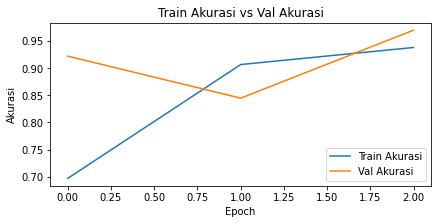

<Figure size 432x288 with 0 Axes>

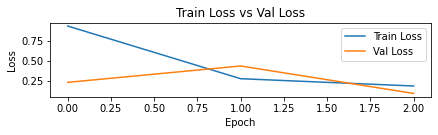

In [39]:
#plot
plt.figure(figsize = (8,6))

trainAcc = history.history['accuracy']
valAcc = history.history['val_accuracy']
trainLoss = history.history['loss']
valLoss = history.history['val_loss']
epoch = range(len(trainAcc))


plt.figure(figsize=(15,3))

#Akurasi Plot
plt.figure(figsize=(15,3))
plt.subplot(1,2,2)
plt.plot(epoch, trainAcc,
         epoch, valAcc)
plt.title('Train Akurasi vs Val Akurasi')
plt.xlabel('Epoch')
plt.ylabel('Akurasi')
plt.legend(['Train Akurasi', 'Val Akurasi'], loc = 0)
plt.show()

plt.tight_layout(pad=1)

#Loss Plot
plt.figure(figsize=(15,3))
plt.subplot(2,2,1)
plt.plot(epoch, trainLoss,
         epoch, valLoss)
plt.title('Train Loss vs Val Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(['Train Loss', 'Val Loss'], loc = 0)
plt.show()

# Memprediksi Data yang belum pernah dilihat 

In [40]:
%cd /SignLanguageProject/data/sign_mnist_test

/SignLanguageProject/data/sign_mnist_test


In [41]:
signTest = pd.read_csv('sign_mnist_test.csv')
signTest.head()

,label,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,pixel9,pixel10,pixel11,pixel12,pixel13,pixel14,pixel15,pixel16,pixel17,pixel18,pixel19,pixel20,pixel21,pixel22,pixel23,pixel24,pixel25,pixel26,pixel27,pixel28,pixel29,pixel30,pixel31,pixel32,pixel33,pixel34,pixel35,pixel36,pixel37,pixel38,pixel39,...,pixel745,pixel746,pixel747,pixel748,pixel749,pixel750,pixel751,pixel752,pixel753,pixel754,pixel755,pixel756,pixel757,pixel758,pixel759,pixel760,pixel761,pixel762,pixel763,pixel764,pixel765,pixel766,pixel767,pixel768,pixel769,pixel770,pixel771,pixel772,pixel773,pixel774,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783,pixel784
0,6,149,149,150,150,150,151,151,150,151,152,152,152,152,152,153,153,151,152,152,153,152,152,151,151,150,150,150,149,150,150,150,152,152,151,152,152,152,152,152,...,131,134,144,147,125,87,87,103,107,110,116,113,75,74,74,74,76,74,82,134,168,155,146,137,145,146,149,135,124,125,138,148,127,89,82,96,106,112,120,107
1,5,126,128,131,132,133,134,135,135,136,138,137,137,138,138,139,137,142,140,138,139,137,137,136,135,134,133,134,132,129,132,134,135,135,137,139,139,139,140,141,...,114,112,89,48,133,194,182,185,184,184,182,181,172,174,177,178,178,179,181,183,187,175,165,154,118,107,100,75,96,83,47,104,194,183,186,184,184,184,182,180
2,10,85,88,92,96,105,123,135,143,147,152,157,163,168,171,182,172,175,185,183,184,185,185,185,183,183,182,181,178,86,88,93,96,108,125,137,145,149,154,160,...,145,123,78,162,239,227,229,226,226,225,224,222,89,91,94,111,136,154,167,184,125,3,166,225,195,188,172,185,161,122,68,166,242,227,230,227,226,225,224,222
3,0,203,205,207,206,207,209,210,209,210,209,208,207,207,209,208,210,210,207,209,209,208,209,210,209,207,208,209,207,206,208,209,208,208,210,211,210,211,209,209,...,85,80,84,151,238,255,255,250,237,245,250,232,103,101,102,103,95,208,231,227,209,190,179,182,152,150,159,119,83,63,154,248,247,248,253,236,230,240,253,255
4,3,188,191,193,195,199,201,202,203,203,203,204,204,204,203,202,198,216,217,135,181,200,195,194,193,190,189,187,185,190,194,196,197,200,202,204,206,207,207,206,...,93,52,24,53,63,33,41,51,48,45,49,55,149,150,150,148,147,151,124,82,84,81,69,81,111,103,84,75,53,28,26,40,64,48,29,46,49,46,46,53


In [84]:
pixelTest = signTest.iloc[:4, 1:]
labelTest = signTest['label'].iloc[:4]

# pixelTest = pixelTest.values.reshape(28,28)
print(pixelTest.shape)

(4, 784)


In [85]:
import numpy as np
predict = model.predict(pixelTest.values.reshape(-1,28,28,1))
predict = np.argmax(predict ,axis = 1)

predict_letter = [letter[i] for i in predict]
actual_letter = [letter[i] for i in labelTest]

print('Actual Letter: ', actual_letter)
print('Predict Letter: ', predict_letter)

Actual Letter:  ['g', 'f', 'k', 'a']
Predict Letter:  ['g', 'f', 'k', 'a']


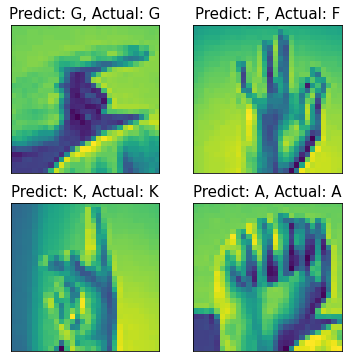

In [93]:
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(6, 6),
                        subplot_kw={'xticks': [], 'yticks': []})

for i, ax in enumerate(axes.flat):
  img = pixelTest.iloc[i].values.reshape(28,28)
  ax.imshow(img)
  title = f"Predict: {predict_letter[i].upper()}, Actual: {actual_letter[i].upper()}"
  ax.set_title(title, fontsize = 15)
plt.show()

# Mengubah menjadi TF-Lite model

In [96]:
#menyimpan model dalam TF-Lite
converter = tf.lite.TFLiteConverter.from_keras_model(model)
tfLiteModel = converter.convert()

with tf.io.gfile.GFile('/SignLanguageProject/data/model.tflite', 'wb') as f:
  f.write(tfLiteModel)

INFO:tensorflow:Assets written to: /tmp/tmpv1bv0qnk/assets


INFO:tensorflow:Assets written to: /tmp/tmpv1bv0qnk/assets
